# start

- http://localhost:8081/notebooks/git/recsys20/working/0324_6_3_lgb_feat_engr-1e7.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/mdl0404_1__xgb_mean_encode.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/eda_0404_1.ipynb#v.s.-target
- https://www.kaggle.com/discdiver/category-encoders-examples
- https://www.kaggle.com/snakayama/lightgbm-using-optuna-optuna-lightgbm

In [6]:
TGT='Reply'
PRFX='Reply0412_1'

trntmstmp=1584412344
tsttmstmp=1586133347

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

SEED=101

valsz = int(5e5)#int(1e5)
trnsz = int(5e5)#int(5e5)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-06 00:35:47']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


In [7]:
(train_total-valsz)/3.7

39885199.459459454

# setup

In [8]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
# import lightgbm as lgb
import category_encoders as ce
import gc

import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
# optuna.logging.set_verbosity(optuna.logging.ERROR)
import optuna.integration.lightgbm as lgb
optuna.logging.disable_default_handler()


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL reply
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [9]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [24]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

(500000, 24)


retwt          0.112638
reply          0.027980
like           0.439010
retwt_cmmnt    0.007676
dtype: float64

CPU times: user 3.9 s, sys: 175 ms, total: 4.07 s
Wall time: 4.07 s


## maybe oversample

In [25]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [26]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

(1850000, 24)


retwt          0.112795
reply          0.027393
like           0.439040
retwt_cmmnt    0.007702
dtype: float64

CPU times: user 13.7 s, sys: 1.54 s, total: 15.3 s
Wall time: 15.3 s


In [27]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

(500000, 24) 0.101354
1850000 50677 500000 50677


,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u1_create_tm,u2id,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,retwt,reply,like,retwt_cmmnt
9,101\t137\t48201\t10133\t44026\t10884\t11305\t9...,NaN,24669C0DADEA57A75F6BE24CAC0ACCB9,Photo,NaN,NaN,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1580948734,A6E0653718DB85566D3E6D1E2989AC6D,145,61,False,1522591408,06E9B9E30FB6A7F37CA6B42264C30103,407,385,False,1274938010,True,False,True,False,False
11,101\t2341\t7911\t121\t12236\t7596\t7431\t12290...,NaN,E15A666B6A975581F5CE3F2286CDB408,Photo,NaN,NaN,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1581344753,74BD974C794C3C2D604E92F9402AB810,318,252,False,1464834037,06E9B9E30FB6A7F37CA6B42264C30103,407,385,False,1274938010,True,False,True,False,False
26,101\t144\t87051\t10354\t16874\t196\t10117\t172...,NaN,D8334D0798821B6A99A9C7A4C9E4E3E1,NaN,8FBB6E6890E2ED0F608F83345CB5EA2F,FFA7BC68DEEFEE9FE34F150D60FEA189,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581149159,4CA2E59BBCCB899954E82B01D61C8DF1,16974,612,False,1397475686,06E9CB2FE3EE244FC5D3E2A7E0B7A460,66,512,False,1498734232,False,False,True,False,False
96,101\t11589\t39520\t18487\t58136\t10121\t10911\...,NaN,0C55DCB7494C90953ACE5E70A46B8AA9,NaN,NaN,NaN,TopLevel,06D61DCBBE938971E1EA0C38BD9B5446,1581470640,58867654CB709C6FBA4F332ED479EF1A,418,554,False,1354395470,06E9F8C1FB619A5AE34B3BE57632DB16,178,339,False,1538938782,True,False,True,True,False
303,101\t65000\t112\t188\t19556\t12172\t10133\t218...,NaN,3058691BBE196B9A3702A8E7584944E9,NaN,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1580980182,B31DCBBAE66B1E22B1531F77538E88E7,19,440,False,1476507467,06EADF03A34F162DE8051C27C439F6BB,172,167,False,1418024844,True,False,True,False,False


Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u2_create_tm', 'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

## prep and features

In [28]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    set_u1 = set(df.u1id)
    set_u2 = set(df.u2id)
    df['u1inu2']=df.u1id.isin(set_u2)
    df['u2inu1']=df.u2id.isin(set_u1)

    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    

    #freq of feature values
    print(dtnow(), 'freq of columns using CountEncoder')
    encoder = ce.CountEncoder()
    encoded = encoder.fit_transform(
    df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
       'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
    encoded = encoded.astype(int)/lendf
    encoded.columns = [f'frq_{col}' for col in encoded.columns]
    df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
    print(dtnow(), 'freq of tags')
    for tgnm in tgnms:
        vs = [j for i in df[f'lst_{tgnm}'] for j in i]
        cnt = Counter(vs)
        frq = {k:v/lendf for k,v in cnt.items()}
        df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
        df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
#     df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)
    df.drop(columns=tgnms,inplace=True)

    print(dtnow(), 'done')
    return df

In [29]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

2020-04-12 15:46:11 start
2020-04-12 15:46:22 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-12 15:46:37 freq of tags
2020-04-12 15:46:41 done
CPU times: user 27.3 s, sys: 3.52 s, total: 30.8 s
Wall time: 30.7 s


In [30]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

2020-04-12 15:46:42 start
2020-04-12 15:46:50 freq of columns using CountEncoder
2020-04-12 15:47:02 freq of tags
2020-04-12 15:47:06 done
CPU times: user 22.8 s, sys: 2.12 s, total: 24.9 s
Wall time: 24.8 s


## tr vl split and target encoding

In [31]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

30

In [32]:
dftr.columns

Index(['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt',
       'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt', 'u1inu2',
       'u2inu1', 'len_toks', 'n_media_Photo', 'n_media_Video', 'n_media_GIF',
       'has_hshtgs', 'lst_hshtgs', 'n_hshtgs', 'has_media', 'lst_media',
       'n_media', 'lst_links', 'has_domns', 'lst_domns', 'n_domns',
       'dayofweek', 'hour', 'tmdlta_u2u1', 'tmdlta_twtu1', 'tmdlta_twtu2',
       'twt_age', 'u1_age', 'u2_age', 'u1_fllwer_cnt_by_age',
       'u1_fllwng_cnt_by_age', 'u1u2', 'langhour', 'frq_twtid', 'frq_twttyp',
       'frq_lang', 'frq_u1id', 'frq_u1_fllwing_cnt', 'frq_u1_vrfed',
       'frq_u2id', 'frq_u2_fllwer_cnt', 'frq_u2_vrfed', 'frq_u1_fllw_u2',
       'frq_n_media_Photo', 'frq_n_media_Video', 'frq_n_media_GIF',
       'frq_has_hshtgs', 'frq_n_hshtgs', 'frq_has_media', 'frq_n_media',
       'frq_has_domns', 'frq_n_domns', 'frq_dayofweek', 'frq

### tgtenc for ordinary cols

In [33]:
%%time
col2tgtenc=['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
   'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
   'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
   'dayofweek', 'hour', 'u1u2', 'langhour']
tgt_encoder = ce.TargetEncoder()
encoded_tr = tgt_encoder.fit_transform(dftr[col2tgtenc].astype(object), dftr[TCOL])
encoded_vl = tgt_encoder.transform(dfvl[col2tgtenc].astype(object))
encoded_val = tgt_encoder.transform(dfval[col2tgtenc].astype(object))

tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tr.columns]
encoded_tr.columns = tgtenc_columns
encoded_vl.columns = tgtenc_columns
encoded_val.columns = tgtenc_columns

dftr = pd.concat([dftr, encoded_tr], 1)
dfvl = pd.concat([dfvl, encoded_vl], 1)
dfval = pd.concat([dfval, encoded_val], 1)


CPU times: user 26.7 s, sys: 1.87 s, total: 28.5 s
Wall time: 28.5 s


In [34]:
cols_category=['twttyp', 'lang', 'langhour']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

### tgtenc for hshtg and domn

In [117]:
tgnm='hshtgs'
lsttgnm=f'lst_{tgnm}'

dftr_has_tgnm = dftr[dftr[lsttgnm].apply(len)>0]

tgnm2lbl_nested = [[(oo,o[1]) for oo in o[0]] for o in zip(dftr_has_tgnm[lsttgnm], dftr_has_tgnm[TCOL])]

tgnm2lbl = [j for i in tgnm2lbl_nested for j in i]

tgnms, lbls = list(zip(*tgnm2lbl))

tgt_encoder = ce.TargetEncoder()
encoded_tr = tgt_encoder.fit(np.array(tgnms), lbls)

In [118]:
set_tgnms = np.array(list(set(tgnms)))
len(set_tgnms)

70750

In [119]:
tgtenc_vs = encoded_tr.transform(set_tgnms)
len(tgtenc_vs)

70750

In [120]:
v2vtgtenc=dict(zip(set_tgnms,tgtenc_vs.values[:,0]))
len(v2vtgtenc)

70750

In [121]:
tgnm2v2vtgtenc={}
for tgnm in ('hshtgs','domns'):
    print(dtnow(), tgnm)
    lsttgnm=f'lst_{tgnm}'
    dftr_has_tgnm = dftr[dftr[lsttgnm].apply(len)>0]
    tgnm2lbl_nested = [[(oo,o[1]) for oo in o[0]] for o in zip(dftr_has_tgnm[lsttgnm], dftr_has_tgnm[TCOL])]
    tgnm2lbl = [j for i in tgnm2lbl_nested for j in i]
    tgnms, lbls = list(zip(*tgnm2lbl))
    tgt_encoder = ce.TargetEncoder()
    encoded_tr = tgt_encoder.fit(np.array(tgnms), lbls)
    set_tgnms = np.array(list(set(tgnms)))
    tgtenc_vs = encoded_tr.transform(set_tgnms)
    v2vtgtenc=dict(zip(set_tgnms,tgtenc_vs.values[:,0]))
    tgnm2v2vtgtenc[tgnm]=v2vtgtenc

2020-04-12 16:09:22 hshtgs
2020-04-12 16:09:23 domns


In [122]:
[len(o) for o in tgnm2v2vtgtenc.values()]

[70750, 12357]

### apply tag2v2vtenc to data

In [127]:
for tgnm in ('hshtgs','domns'):
    v2vtgtenc=tgnm2v2vtgtenc[tgnm]
    for df in [dftr,dfvl,dfval]:
        df[f'sumtgtenc_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([v2vtgtenc.get(o,0) for o in x]))
        df[f'maxtgtenc_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([v2vtgtenc.get(o,0) for o in x]) if len(x) else 0)

# model

In [130]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

## cols_feat

In [132]:
print(len(cols_feat))
cols_feat=['twttyp',
 'lang',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'u1inu2',
 'u2inu1',
 'len_toks',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
#  'has_hshtgs',
 'n_hshtgs',
#  'has_media',
 'n_media',
#  'has_domns',
 'n_domns',
 'dayofweek',
 'hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_age',
 'u2_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'langhour',
 'frq_twtid',
#  'frq_twttyp',
#  'frq_lang',
 'frq_u1id',
#  'frq_u1_fllwing_cnt',
#  'frq_u1_vrfed',
 'frq_u2id',
#  'frq_u2_fllwer_cnt',
#  'frq_u2_vrfed',
#  'frq_u1_fllw_u2',
#  'frq_n_media_Photo',
#  'frq_n_media_Video',
#  'frq_n_media_GIF',
#  'frq_has_hshtgs',
#  'frq_n_hshtgs',
#  'frq_has_media',
#  'frq_n_media',
#  'frq_has_domns',
#  'frq_n_domns',
#  'frq_dayofweek',
#  'frq_hour',
 'frq_u1u2',
#  'frq_langhour',
 'sumfrq_hshtgs',
#  'maxfrq_hshtgs',
#  'sumfrq_media',
#  'maxfrq_media',
#  'sumfrq_links',
#  'maxfrq_links',
 'sumfrq_domns',
#  'maxfrq_domns',
#  'tgtenc_twtid',
#  'tgtenc_twttyp',
 'tgtenc_lang',
#  'tgtenc_u1id',
#  'tgtenc_u1_fllwing_cnt',
#  'tgtenc_u1_vrfed',
#  'tgtenc_u2id',
#  'tgtenc_u2_fllwer_cnt',
#  'tgtenc_u2_vrfed',
#  'tgtenc_u1_fllw_u2',
#  'tgtenc_n_media_Photo',
#  'tgtenc_n_media_Video',
#  'tgtenc_n_media_GIF',
#  'tgtenc_has_hshtgs',
#  'tgtenc_n_hshtgs',
#  'tgtenc_has_media',
#  'tgtenc_n_media',
#  'tgtenc_has_domns',
#  'tgtenc_n_domns',
#  'tgtenc_dayofweek',
#  'tgtenc_hour',
#  'tgtenc_u1u2',
#  'tgtenc_langhour'
           'sumtgtenc_domns',
 'maxtgtenc_domns',
 'sumtgtenc_hshtgs',
 'maxtgtenc_hshtgs']
print(len(cols_feat))

94
40


In [133]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat
results['tgt_encoder'] = tgt_encoder
results['col2tgtenc'] = col2tgtenc

In [134]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,    
}
results['params'] = params

In [137]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
best_params, tuning_history = {}, []
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                best_params=best_params,
                tuning_history=tuning_history,
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres
results['best_params']=best_params
results['tuning_history']=tuning_history

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.258541	vl's binary_logloss: 0.291821
Early stopping, best iteration is:
[45]	tr's binary_logloss: 0.267384	vl's binary_logloss: 0.290027


tune_feature_fraction, val_score: 0.290027:  14%|#4        | 1/7 [00:08<00:42,  7.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.257861	vl's binary_logloss: 0.293546
Early stopping, best iteration is:
[41]	tr's binary_logloss: 0.26741	vl's binary_logloss: 0.289753


tune_feature_fraction, val_score: 0.289753:  29%|##8       | 2/7 [00:13<00:33,  6.62s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.257089	vl's binary_logloss: 0.294353
Early stopping, best iteration is:
[41]	tr's binary_logloss: 0.266505	vl's binary_logloss: 0.289751


tune_feature_fraction, val_score: 0.289751:  43%|####2     | 3/7 [00:18<00:24,  6.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.25673	vl's binary_logloss: 0.293566
Early stopping, best iteration is:
[31]	tr's binary_logloss: 0.269674	vl's binary_logloss: 0.289756


tune_feature_fraction, val_score: 0.289751:  57%|#####7    | 4/7 [00:22<00:16,  5.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.25653	vl's binary_logloss: 0.295354
Early stopping, best iteration is:
[31]	tr's binary_logloss: 0.269257	vl's binary_logloss: 0.289622


tune_feature_fraction, val_score: 0.289622:  71%|#######1  | 5/7 [00:27<00:10,  5.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.255623	vl's binary_logloss: 0.295036
Early stopping, best iteration is:
[31]	tr's binary_logloss: 0.268472	vl's binary_logloss: 0.289581


tune_feature_fraction, val_score: 0.289581:  86%|########5 | 6/7 [00:31<00:05,  5.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.25506	vl's binary_logloss: 0.296279
Early stopping, best iteration is:
[27]	tr's binary_logloss: 0.270227	vl's binary_logloss: 0.289549


tune_num_leaves, val_score: 0.289549:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.209207	vl's binary_logloss: 0.304617
Early stopping, best iteration is:
[21]	tr's binary_logloss: 0.254828	vl's binary_logloss: 0.290518


tune_num_leaves, val_score: 0.289549:   5%|5         | 1/20 [00:09<02:47,  8.79s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.256002	vl's binary_logloss: 0.295653
Early stopping, best iteration is:
[25]	tr's binary_logloss: 0.271748	vl's binary_logloss: 0.289562


tune_num_leaves, val_score: 0.289549:  10%|#         | 2/20 [00:14<02:16,  7.59s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.209557	vl's binary_logloss: 0.303412
Early stopping, best iteration is:
[21]	tr's binary_logloss: 0.254906	vl's binary_logloss: 0.290176


tune_num_leaves, val_score: 0.289549:  15%|#5        | 3/20 [00:23<02:17,  8.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.216793	vl's binary_logloss: 0.302848
Early stopping, best iteration is:
[20]	tr's binary_logloss: 0.258445	vl's binary_logloss: 0.290146


tune_num_leaves, val_score: 0.289549:  20%|##        | 4/20 [00:32<02:11,  8.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242162	vl's binary_logloss: 0.29797
Early stopping, best iteration is:
[30]	tr's binary_logloss: 0.261868	vl's binary_logloss: 0.289774


tune_num_leaves, val_score: 0.289549:  25%|##5       | 5/20 [00:38<01:52,  7.51s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.247293	vl's binary_logloss: 0.297431
Early stopping, best iteration is:
[25]	tr's binary_logloss: 0.267043	vl's binary_logloss: 0.289779


tune_num_leaves, val_score: 0.289549:  30%|###       | 6/20 [00:43<01:34,  6.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.240562	vl's binary_logloss: 0.29929
Early stopping, best iteration is:
[22]	tr's binary_logloss: 0.26573	vl's binary_logloss: 0.290041


tune_num_leaves, val_score: 0.289549:  35%|###5      | 7/20 [00:48<01:24,  6.47s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.245949	vl's binary_logloss: 0.297702
Early stopping, best iteration is:
[24]	tr's binary_logloss: 0.266687	vl's binary_logloss: 0.289615


tune_num_leaves, val_score: 0.289549:  40%|####      | 8/20 [00:53<01:12,  6.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.210155	vl's binary_logloss: 0.30361
Early stopping, best iteration is:
[23]	tr's binary_logloss: 0.253055	vl's binary_logloss: 0.290186


tune_num_leaves, val_score: 0.289549:  45%|####5     | 9/20 [01:02<01:16,  6.93s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.221954	vl's binary_logloss: 0.302713
Early stopping, best iteration is:
[25]	tr's binary_logloss: 0.255765	vl's binary_logloss: 0.290136


tune_num_leaves, val_score: 0.289549:  50%|#####     | 10/20 [01:10<01:12,  7.26s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263789	vl's binary_logloss: 0.292609
Early stopping, best iteration is:
[38]	tr's binary_logloss: 0.271958	vl's binary_logloss: 0.289595


tune_num_leaves, val_score: 0.289549:  55%|#####5    | 11/20 [01:14<00:55,  6.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.265073	vl's binary_logloss: 0.292348
Early stopping, best iteration is:
[34]	tr's binary_logloss: 0.273941	vl's binary_logloss: 0.289949


tune_num_leaves, val_score: 0.289549:  60%|######    | 12/20 [01:17<00:42,  5.34s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.271237	vl's binary_logloss: 0.29129
Early stopping, best iteration is:
[56]	tr's binary_logloss: 0.274977	vl's binary_logloss: 0.290948


tune_num_leaves, val_score: 0.289549:  65%|######5   | 13/20 [01:21<00:32,  4.70s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.23234	vl's binary_logloss: 0.300041
Early stopping, best iteration is:
[24]	tr's binary_logloss: 0.260608	vl's binary_logloss: 0.29002


tune_num_leaves, val_score: 0.289549:  70%|#######   | 14/20 [01:27<00:30,  5.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.258706	vl's binary_logloss: 0.2946
Early stopping, best iteration is:
[29]	tr's binary_logloss: 0.271647	vl's binary_logloss: 0.289614


tune_num_leaves, val_score: 0.289549:  75%|#######5  | 15/20 [01:31<00:24,  4.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.232284	vl's binary_logloss: 0.300389
Early stopping, best iteration is:
[24]	tr's binary_logloss: 0.260722	vl's binary_logloss: 0.290223


tune_num_leaves, val_score: 0.289549:  80%|########  | 16/20 [01:37<00:20,  5.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253124	vl's binary_logloss: 0.296109
Early stopping, best iteration is:
[26]	tr's binary_logloss: 0.269577	vl's binary_logloss: 0.289462


tune_num_leaves, val_score: 0.289462:  85%|########5 | 17/20 [01:41<00:14,  4.96s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.25252	vl's binary_logloss: 0.296098
Early stopping, best iteration is:
[27]	tr's binary_logloss: 0.268802	vl's binary_logloss: 0.28958


tune_num_leaves, val_score: 0.289462:  90%|######### | 18/20 [01:46<00:09,  4.93s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.237725	vl's binary_logloss: 0.299257
Early stopping, best iteration is:
[26]	tr's binary_logloss: 0.261746	vl's binary_logloss: 0.289784


tune_num_leaves, val_score: 0.289462:  95%|#########5| 19/20 [01:53<00:05,  5.31s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.226275	vl's binary_logloss: 0.30113
Early stopping, best iteration is:
[24]	tr's binary_logloss: 0.258289	vl's binary_logloss: 0.289911


tune_num_leaves, val_score: 0.289462: 100%|##########| 20/20 [01:59<00:00,  6.00s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.289462:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.254608	vl's binary_logloss: 0.295379
Early stopping, best iteration is:
[27]	tr's binary_logloss: 0.269399	vl's binary_logloss: 0.289542


tune_bagging_fraction_and_bagging_freq, val_score: 0.289462:  10%|#         | 1/10 [00:05<00:40,  4.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.255631	vl's binary_logloss: 0.295441
Early stopping, best iteration is:
[32]	tr's binary_logloss: 0.267504	vl's binary_logloss: 0.289621


tune_bagging_fraction_and_bagging_freq, val_score: 0.289462:  20%|##        | 2/10 [00:10<00:38,  4.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.259066	vl's binary_logloss: 0.294264
Early stopping, best iteration is:
[32]	tr's binary_logloss: 0.268995	vl's binary_logloss: 0.289811


tune_bagging_fraction_and_bagging_freq, val_score: 0.289462:  30%|###       | 3/10 [00:15<00:32,  4.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.256355	vl's binary_logloss: 0.295787
Early stopping, best iteration is:
[29]	tr's binary_logloss: 0.269181	vl's binary_logloss: 0.289593


tune_bagging_fraction_and_bagging_freq, val_score: 0.289462:  40%|####      | 4/10 [00:20<00:28,  4.79s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.255963	vl's binary_logloss: 0.296603
Early stopping, best iteration is:
[26]	tr's binary_logloss: 0.270081	vl's binary_logloss: 0.290096


tune_bagging_fraction_and_bagging_freq, val_score: 0.289462:  50%|#####     | 5/10 [00:25<00:25,  5.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.256385	vl's binary_logloss: 0.296159
Early stopping, best iteration is:
[31]	tr's binary_logloss: 0.268132	vl's binary_logloss: 0.289683


tune_bagging_fraction_and_bagging_freq, val_score: 0.289462:  60%|######    | 6/10 [00:31<00:20,  5.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.259536	vl's binary_logloss: 0.294454
Early stopping, best iteration is:
[28]	tr's binary_logloss: 0.270615	vl's binary_logloss: 0.290044


tune_bagging_fraction_and_bagging_freq, val_score: 0.289462:  70%|#######   | 7/10 [00:35<00:14,  4.87s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.255146	vl's binary_logloss: 0.295835
Early stopping, best iteration is:
[26]	tr's binary_logloss: 0.269833	vl's binary_logloss: 0.289682


tune_bagging_fraction_and_bagging_freq, val_score: 0.289462:  80%|########  | 8/10 [00:41<00:10,  5.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.255535	vl's binary_logloss: 0.296408
Early stopping, best iteration is:
[27]	tr's binary_logloss: 0.269544	vl's binary_logloss: 0.28978


tune_bagging_fraction_and_bagging_freq, val_score: 0.289462:  90%|######### | 9/10 [00:45<00:05,  5.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253691	vl's binary_logloss: 0.296279
Early stopping, best iteration is:
[27]	tr's binary_logloss: 0.269292	vl's binary_logloss: 0.289775


tune_bagging_fraction_and_bagging_freq, val_score: 0.289462: 100%|##########| 10/10 [00:51<00:00,  5.18s/it]
tune_feature_fraction, val_score: 0.289462:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.2535	vl's binary_logloss: 0.295683
Early stopping, best iteration is:
[27]	tr's binary_logloss: 0.26934	vl's binary_logloss: 0.2894


tune_feature_fraction, val_score: 0.289400:  33%|###3      | 1/3 [00:04<00:06,  3.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253359	vl's binary_logloss: 0.296063
Early stopping, best iteration is:
[27]	tr's binary_logloss: 0.26913	vl's binary_logloss: 0.289374


tune_feature_fraction, val_score: 0.289374:  67%|######6   | 2/3 [00:08<00:03,  3.73s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253127	vl's binary_logloss: 0.296657
Early stopping, best iteration is:
[26]	tr's binary_logloss: 0.26957	vl's binary_logloss: 0.289355


tune_feature_fraction, val_score: 0.289355: 100%|##########| 3/3 [00:12<00:00,  4.25s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.289355:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253314	vl's binary_logloss: 0.297067
Early stopping, best iteration is:
[25]	tr's binary_logloss: 0.270229	vl's binary_logloss: 0.289427


tune_lambda_l1_and_lambda_l2, val_score: 0.289355:   5%|5         | 1/20 [00:04<01:09,  3.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253295	vl's binary_logloss: 0.296034
Early stopping, best iteration is:
[27]	tr's binary_logloss: 0.269165	vl's binary_logloss: 0.289728


tune_lambda_l1_and_lambda_l2, val_score: 0.289355:  10%|#         | 2/20 [00:08<01:10,  3.94s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253221	vl's binary_logloss: 0.29696
Early stopping, best iteration is:
[25]	tr's binary_logloss: 0.270251	vl's binary_logloss: 0.289472


tune_lambda_l1_and_lambda_l2, val_score: 0.289355:  15%|#5        | 3/20 [00:13<01:09,  4.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253207	vl's binary_logloss: 0.296577
Early stopping, best iteration is:
[26]	tr's binary_logloss: 0.269698	vl's binary_logloss: 0.289249


tune_lambda_l1_and_lambda_l2, val_score: 0.289249:  20%|##        | 4/20 [00:17<01:06,  4.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.2537	vl's binary_logloss: 0.297499
Early stopping, best iteration is:
[29]	tr's binary_logloss: 0.26876	vl's binary_logloss: 0.28939


tune_lambda_l1_and_lambda_l2, val_score: 0.289249:  25%|##5       | 5/20 [00:22<01:05,  4.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253451	vl's binary_logloss: 0.295786
Early stopping, best iteration is:
[25]	tr's binary_logloss: 0.270197	vl's binary_logloss: 0.2895


tune_lambda_l1_and_lambda_l2, val_score: 0.289249:  30%|###       | 6/20 [00:26<01:01,  4.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253285	vl's binary_logloss: 0.296173
Early stopping, best iteration is:
[27]	tr's binary_logloss: 0.269104	vl's binary_logloss: 0.289532


tune_lambda_l1_and_lambda_l2, val_score: 0.289249:  35%|###5      | 7/20 [00:32<01:00,  4.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253128	vl's binary_logloss: 0.296657
Early stopping, best iteration is:
[26]	tr's binary_logloss: 0.26957	vl's binary_logloss: 0.289355


tune_lambda_l1_and_lambda_l2, val_score: 0.289249:  40%|####      | 8/20 [00:36<00:55,  4.62s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253128	vl's binary_logloss: 0.296657
Early stopping, best iteration is:
[26]	tr's binary_logloss: 0.26957	vl's binary_logloss: 0.289355


tune_lambda_l1_and_lambda_l2, val_score: 0.289249:  45%|####5     | 9/20 [00:40<00:49,  4.50s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253127	vl's binary_logloss: 0.296657
Early stopping, best iteration is:
[26]	tr's binary_logloss: 0.26957	vl's binary_logloss: 0.289355


tune_lambda_l1_and_lambda_l2, val_score: 0.289249:  50%|#####     | 10/20 [00:45<00:45,  4.60s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253098	vl's binary_logloss: 0.296264
Early stopping, best iteration is:
[24]	tr's binary_logloss: 0.270638	vl's binary_logloss: 0.289638


tune_lambda_l1_and_lambda_l2, val_score: 0.289249:  55%|#####5    | 11/20 [00:50<00:40,  4.54s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.252979	vl's binary_logloss: 0.296839
Early stopping, best iteration is:
[26]	tr's binary_logloss: 0.269615	vl's binary_logloss: 0.289621


tune_lambda_l1_and_lambda_l2, val_score: 0.289249:  60%|######    | 12/20 [00:54<00:35,  4.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253122	vl's binary_logloss: 0.296596
Early stopping, best iteration is:
[26]	tr's binary_logloss: 0.269615	vl's binary_logloss: 0.289621


tune_lambda_l1_and_lambda_l2, val_score: 0.289249:  65%|######5   | 13/20 [00:58<00:31,  4.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253388	vl's binary_logloss: 0.296474
Early stopping, best iteration is:
[25]	tr's binary_logloss: 0.270685	vl's binary_logloss: 0.289327


tune_lambda_l1_and_lambda_l2, val_score: 0.289249:  70%|#######   | 14/20 [01:04<00:27,  4.64s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253758	vl's binary_logloss: 0.29722
Early stopping, best iteration is:
[24]	tr's binary_logloss: 0.271146	vl's binary_logloss: 0.28949


tune_lambda_l1_and_lambda_l2, val_score: 0.289249:  75%|#######5  | 15/20 [01:08<00:23,  4.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253149	vl's binary_logloss: 0.296792
Early stopping, best iteration is:
[26]	tr's binary_logloss: 0.269732	vl's binary_logloss: 0.289375


tune_lambda_l1_and_lambda_l2, val_score: 0.289249:  80%|########  | 16/20 [01:13<00:18,  4.58s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253177	vl's binary_logloss: 0.296759
Early stopping, best iteration is:
[27]	tr's binary_logloss: 0.269219	vl's binary_logloss: 0.289369


tune_lambda_l1_and_lambda_l2, val_score: 0.289249:  85%|########5 | 17/20 [01:17<00:13,  4.57s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253295	vl's binary_logloss: 0.297167
Early stopping, best iteration is:
[26]	tr's binary_logloss: 0.269803	vl's binary_logloss: 0.28954


tune_lambda_l1_and_lambda_l2, val_score: 0.289249:  90%|######### | 18/20 [01:21<00:09,  4.50s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253411	vl's binary_logloss: 0.296865
Early stopping, best iteration is:
[28]	tr's binary_logloss: 0.268963	vl's binary_logloss: 0.28932


tune_lambda_l1_and_lambda_l2, val_score: 0.289249:  95%|#########5| 19/20 [01:26<00:04,  4.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253215	vl's binary_logloss: 0.296543
Early stopping, best iteration is:
[24]	tr's binary_logloss: 0.270585	vl's binary_logloss: 0.28974


tune_lambda_l1_and_lambda_l2, val_score: 0.289249: 100%|##########| 20/20 [01:30<00:00,  4.53s/it]
tune_min_child_samples, val_score: 0.289249:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.25313	vl's binary_logloss: 0.296215
Early stopping, best iteration is:
[26]	tr's binary_logloss: 0.269527	vl's binary_logloss: 0.289427


tune_min_child_samples, val_score: 0.289249:  20%|##        | 1/5 [00:04<00:15,  3.98s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253187	vl's binary_logloss: 0.296584
Early stopping, best iteration is:
[26]	tr's binary_logloss: 0.269527	vl's binary_logloss: 0.289427


tune_min_child_samples, val_score: 0.289249:  40%|####      | 2/5 [00:09<00:12,  4.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.252999	vl's binary_logloss: 0.29636
Early stopping, best iteration is:
[26]	tr's binary_logloss: 0.269698	vl's binary_logloss: 0.289249


tune_min_child_samples, val_score: 0.289249:  60%|######    | 3/5 [00:13<00:08,  4.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253214	vl's binary_logloss: 0.296886
Early stopping, best iteration is:
[26]	tr's binary_logloss: 0.269654	vl's binary_logloss: 0.289512


tune_min_child_samples, val_score: 0.289249:  80%|########  | 4/5 [00:18<00:04,  4.38s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253155	vl's binary_logloss: 0.296997
Early stopping, best iteration is:
[28]	tr's binary_logloss: 0.268795	vl's binary_logloss: 0.289376


tune_min_child_samples, val_score: 0.289249: 100%|##########| 5/5 [00:23<00:00,  4.63s/it]


CPU times: user 50min 43s, sys: 1h 39min 56s, total: 2h 30min 40s
Wall time: 5min 35s


## best_params

In [138]:
best_params

{'lambda_l1': 1.0496642492770891,
 'lambda_l2': 9.41580209160284e-08,
 'num_leaves': 36,
 'feature_fraction': 0.9840000000000001,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

## tr vl trajec

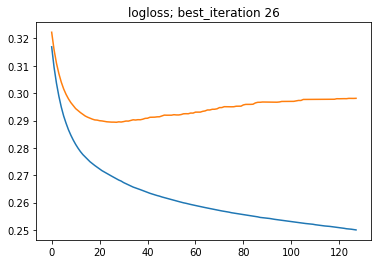

In [139]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

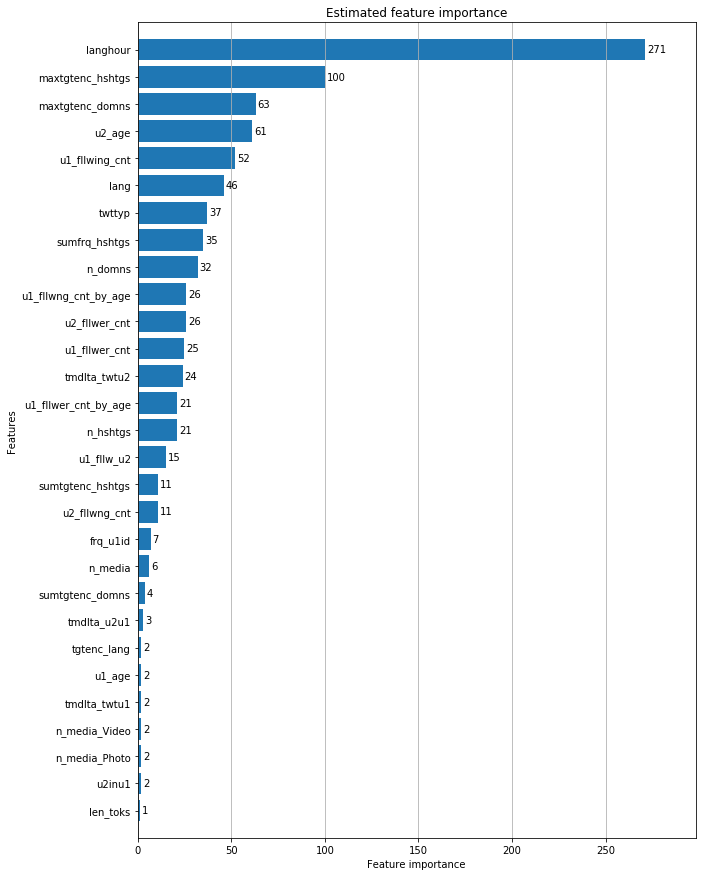

In [140]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [141]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
28,langhour,271
39,maxtgtenc_hshtgs,100
37,maxtgtenc_domns,63
25,u2_age,61
3,u1_fllwing_cnt,52
1,lang,46
0,twttyp,37
33,sumfrq_hshtgs,35
17,n_domns,32
27,u1_fllwng_cnt_by_age,26


In [142]:
col2imp = dict(zip(bst.feature_name(), bst.feature_importance()))
sorted(col2imp.items(), key=lambda x: -x[1])

[('langhour', 271),
 ('maxtgtenc_hshtgs', 100),
 ('maxtgtenc_domns', 63),
 ('u2_age', 61),
 ('u1_fllwing_cnt', 52),
 ('lang', 46),
 ('twttyp', 37),
 ('sumfrq_hshtgs', 35),
 ('n_domns', 32),
 ('u2_fllwer_cnt', 26),
 ('u1_fllwng_cnt_by_age', 26),
 ('u1_fllwer_cnt', 25),
 ('tmdlta_twtu2', 24),
 ('n_hshtgs', 21),
 ('u1_fllwer_cnt_by_age', 21),
 ('u1_fllw_u2', 15),
 ('u2_fllwng_cnt', 11),
 ('sumtgtenc_hshtgs', 11),
 ('frq_u1id', 7),
 ('n_media', 6),
 ('sumtgtenc_domns', 4),
 ('tmdlta_u2u1', 3),
 ('u2inu1', 2),
 ('n_media_Photo', 2),
 ('n_media_Video', 2),
 ('tmdlta_twtu1', 2),
 ('u1_age', 2),
 ('tgtenc_lang', 2),
 ('len_toks', 1),
 ('u1_vrfed', 0),
 ('u2_vrfed', 0),
 ('u1inu2', 0),
 ('n_media_GIF', 0),
 ('dayofweek', 0),
 ('hour', 0),
 ('twt_age', 0),
 ('frq_twtid', 0),
 ('frq_u2id', 0),
 ('frq_u1u2', 0),
 ('sumfrq_domns', 0)]

In [143]:
[o[0] for o in sorted(col2imp.items(), key=lambda x: -x[1]) if o[1]>0]

['langhour',
 'maxtgtenc_hshtgs',
 'maxtgtenc_domns',
 'u2_age',
 'u1_fllwing_cnt',
 'lang',
 'twttyp',
 'sumfrq_hshtgs',
 'n_domns',
 'u2_fllwer_cnt',
 'u1_fllwng_cnt_by_age',
 'u1_fllwer_cnt',
 'tmdlta_twtu2',
 'n_hshtgs',
 'u1_fllwer_cnt_by_age',
 'u1_fllw_u2',
 'u2_fllwng_cnt',
 'sumtgtenc_hshtgs',
 'frq_u1id',
 'n_media',
 'sumtgtenc_domns',
 'tmdlta_u2u1',
 'u2inu1',
 'n_media_Photo',
 'n_media_Video',
 'tmdlta_twtu1',
 'u1_age',
 'tgtenc_lang',
 'len_toks']

# eval

In [144]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 12.1 s, sys: 14.9 s, total: 27 s
Wall time: 6 s


In [145]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

CPU times: user 3.12 s, sys: 1.09 s, total: 4.21 s
Wall time: 3.68 s


In [146]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.3425
auc_vl:  0.2654
auc_val: 0.0893

rce_tr:  17.6502
rce_vl:  12.6450
rce_val: 10.0572


## score

In [147]:
print(f'-{auc_val:.4f}-{rce_val:.4f}')

-0.0893-10.0572


# save results

In [148]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [ ]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
col2tgtenc = results['col2tgtenc']
cols_feat = results['cols_feat']
tgt_encoder = results['tgt_encoder']

## prep

In [ ]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
    nrows=10
)

In [ ]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

In [ ]:
encoded_tst = tgt_encoder.transform(dftst[col2tgtenc].astype(object))
tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tst.columns]
encoded_tst.columns = tgtenc_columns
dftst = pd.concat([dftst, encoded_tst], 1)
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

## predict

In [ ]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

In [ ]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)